### Agent-Lab: Vision Document Agent

Objective of this notebook is evaluating and adapting the implementation of [Multi-modal Agent](https://python.langchain.com/docs/integrations/llms/ollama/#multi-modal) specialized on documents.

#### Preparation steps:

Before executing the notebook perform the following preparation steps.

1. Start Docker containers: `docker compose up -d --build`

2. Verify application is up and running, with web browser: `http://localhost:18000/docs`

3. Inside project root directory, create a `.env` file with env vars with correct values:

    ```
    DEVELOPING="True"
    OLLAMA_ENDPOINT="http://localhost:11434"
    ```

---

In [1]:
%%capture

import os
os.chdir('..')

from dotenv import load_dotenv
load_dotenv()

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
agent = experiment_utils.create_ollama_agent(
    agent_type="vision_document",
    llm_tag="granite3.2-vision:latest",
    ollama_endpoint=os.getenv("OLLAMA_ENDPOINT")
)

# create first attachment
first_attachment_id = experiment_utils.create_attachment(
    file_path="tests/integration/vision_document_01.png",
    content_type="image/png"
)

# create second attachment
second_attachment_id = experiment_utils.create_attachment(
    file_path="tests/integration/vision_document_02.png",
    content_type="image/png"
)

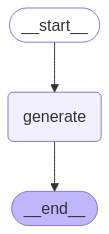

In [3]:
# get agent instance
vision_document_agent = container.vision_document_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# Create Graph
workflow_builder = vision_document_agent.get_workflow_builder(agent["id"])
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

In [4]:
agent_config = {
    "configurable": {
        "thread_id": agent["id"],
    },
    "recursion_limit": 30
}

In [6]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Describe this image, generate data for study material. You can use up to three paragraphs to describe.",
    agent_id=agent["id"],
    attachment_id=first_attachment_id
)

inputs = vision_document_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [ ]:
print(result.keys())

In [ ]:
print(result['generation'])

In [ ]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Describe this image, generate data for study material. You can use up to three paragraphs to describe.",
    agent_id=agent["id"],
    attachment_id=second_attachment_id
)

inputs = vision_document_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [ ]:
print(result['generation'])